In [23]:
from assignment_2_final import *


Training CNN-1 with filters [32, 64, 128] ...
  -> Train accuracy: 0.9989
  -> Test accuracy:  0.9907
  -> Parameters:    227,306
  -> Training time: 267.21 seconds



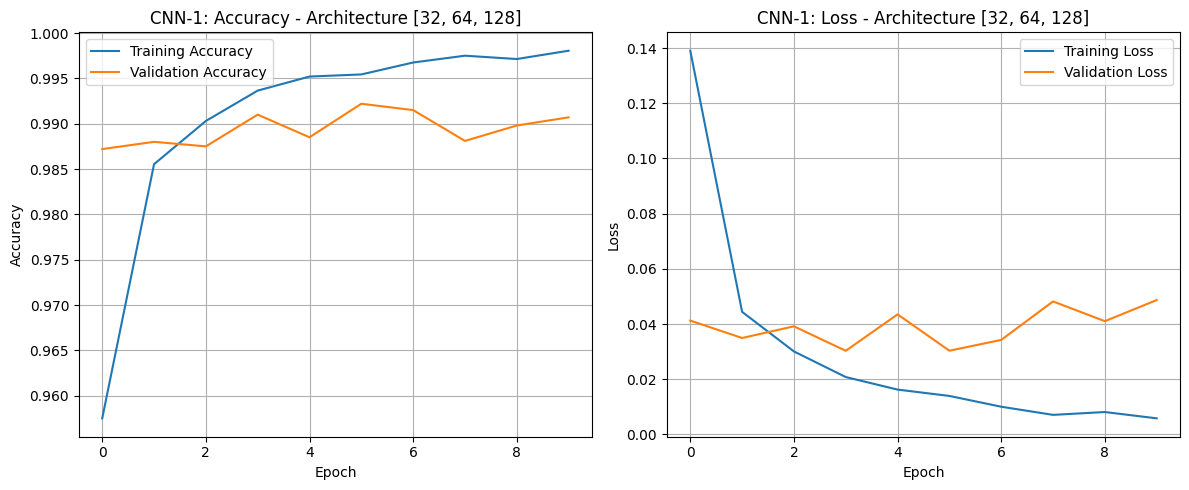

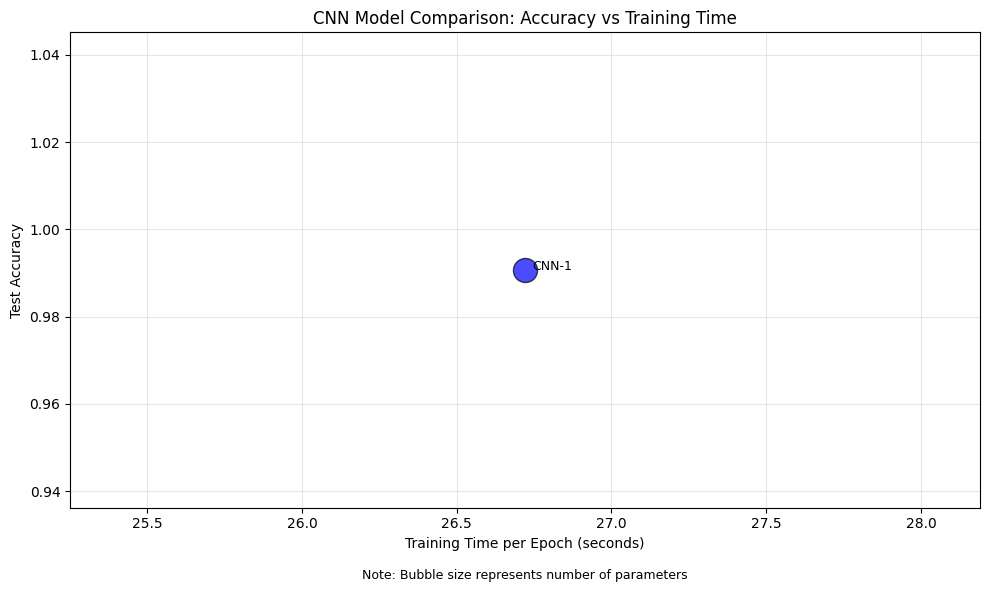

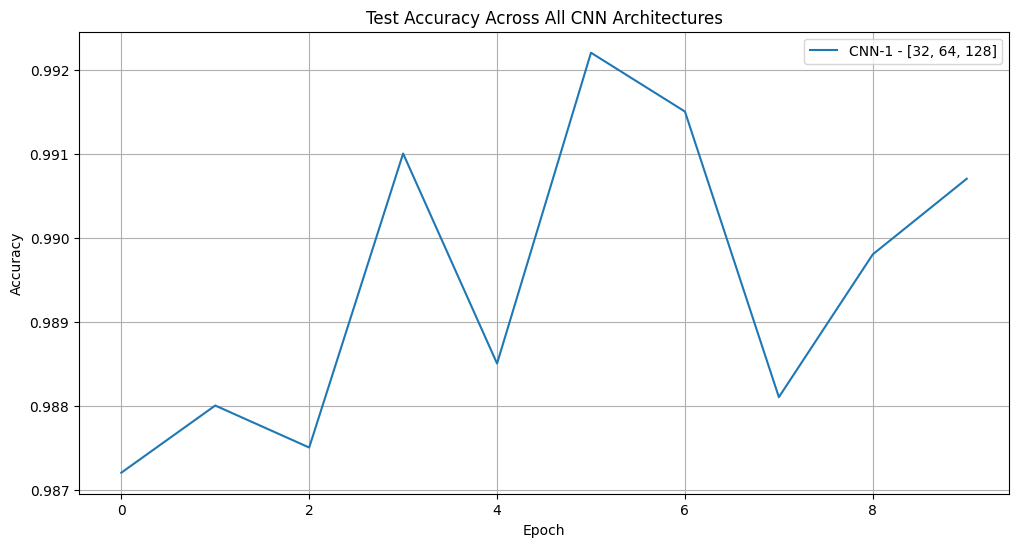


CNN Architecture Comparison Summary:


,CNN,Architecture,Layers,Parameters,Train Accuracy,Test Accuracy,Training Time (s)
0,CNN-1,"[32, 64, 128]",3,"227,306",0.9989,0.9907,267.21


In [27]:
# Run Task 4

cnn_architectures = {
    'CNN-1': [32, 64, 128],
    # 'CNN-2': [64, 128],
    # 'CNN-3': [128, 128, 128],
    # 'CNN-4': [16, 32],
    # 'CNN-5': [32, 64, 128, 256, 512]
}

base_cnn_model, cnn_df = run_task4(cnn_architectures=cnn_architectures, epochs=10)

In [28]:
# Task 5 code


def plot_filters(model, layer_idx, cols):
    layer = model.layers[layer_idx]
    if not isinstance(layer, layers.Conv2D):
        print(f"Layer {layer_idx} is not a convolutional layer.")
        return
    
    filters, _ = layer.get_weights()
    n_filters = filters.shape[-1]
    rows = int(np.ceil(n_filters / cols))
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_filters):
        plt.subplot(rows, cols, i + 1)
        # Average across channels if multi-channel
        filter_img = filters[:, :, 0, i] if filters.shape[2] == 1 else np.mean(filters[:, :, :, i], axis=2)
        filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min() + 1e-7)
        plt.imshow(filter_img, cmap='viridis')
        plt.axis('off')
        plt.title(f'{i+1}', fontsize=8)
    plt.suptitle(f'Filters of {layer.name}')
    plt.tight_layout()
    plt.show()

def plot_activations(model, image, layer_indices, digit_class, cols):
    # Add batch dimension if needed
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)

    # Define activation models outside the loop to avoid retracing
    activation_models = {}
    for layer_idx in layer_indices:
        layer = model.layers[layer_idx]
        if not isinstance(layer, tf.keras.layers.Conv2D):
            continue

        # Create submodel to extract activations
        input_tensor = tf.keras.Input(shape=(28, 28, 1))
        x = input_tensor
        for l in model.layers[:layer_idx + 1]:
            x = l(x)
        activation_models[layer_idx] = tf.keras.models.Model(inputs=input_tensor, outputs=x)

    # Use the pre-defined models to get activations
    for layer_idx in layer_indices:
        layer = model.layers[layer_idx]
        if not isinstance(layer, tf.keras.layers.Conv2D):
            continue

        activations = activation_models[layer_idx].predict(image, verbose=0)

        n_filters = activations.shape[-1]
        rows = int(np.ceil(n_filters / cols))

        plt.figure(figsize=(cols * 2, rows * 2))
        for i in range(n_filters):
            plt.subplot(rows, cols, i + 1)
            activation = activations[0, :, :, i]
    
            activation = (activation - activation.min()) / (activation.max() - activation.min() + 1e-7)
            plt.imshow(activation, cmap='viridis')
            plt.axis('off')
            plt.title(f'Filter {i+1}')
        plt.suptitle(f'Activations of {layer.name} for Digit {digit_class}')
        plt.tight_layout()
        plt.show()

def generate_deep_dream(model, class_idx, x_test, y_test, dream_iterations, dream_learning_rate):
    # Start with random noise (better initial point than pure noise)
    seed_idx = np.where(y_test == class_idx)[0][0]
    seed_img = x_test[seed_idx:seed_idx+1] * 0.1
    # Add noise
    img = seed_img + np.random.normal(0, 0.2, seed_img.shape)
    img = tf.Variable(img, dtype=tf.float32)

    # Optimisation loop
    for i in range(dream_iterations):
        with tf.GradientTape() as tape:
            # Watch the input image
            tape.watch(img)
            # Get model prediction
            pred = model(img)
            # Loss is negative of target class activation (we want to maximise it)
            loss = -pred[0, class_idx]

        # Calculate gradients
        grads = tape.gradient(loss, img)
        # Normalize gradients
        grads = tf.math.l2_normalize(grads)
        # Update the image
        img.assign_sub(grads * dream_learning_rate)

        # Periodically normalise
        if i % 10 == 0:
            img_np = img.numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
            img.assign(tf.convert_to_tensor(img_np, dtype=tf.float32))

    # Final normalisation
    img_np = img.numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

    return img_np[0, :, :, 0]

def plot_deep_dream(model, dream_iterations, dream_learning_rate):

    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalise pixel values to be between 0 and 1
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # Reshape for CNN input
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)

    # Generate deep dream images
    dream_2 = generate_deep_dream(model, 2, x_test, y_test, dream_iterations, dream_learning_rate)
    dream_9 = generate_deep_dream(model, 9, x_test, y_test, dream_iterations, dream_learning_rate)


    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(dream_2, cmap='viridis')
    plt.title("Deep Dream: Digit 2")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(dream_9, cmap='viridis')
    plt.title("Deep Dream: Digit 9")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('deep_dream_mnist.png')
    plt.show()

def run_task5(model, digit_pairs, dream_iterations=700, dream_learning_rate=0.05):
    _, X_test_flatened, _, y_test_raw = load_mnist_data()
    
    n_test = X_test_flatened.shape[0]
    x_test = X_test_flatened.reshape(n_test, 28, 28, 1)
    
    y_test = tf.keras.utils.to_categorical(y_test_raw, 10)
    
    conv_layer_indices = [i for i, layer in enumerate(model.layers) if isinstance(layer, layers.Conv2D)]
    
    digit_classes = digit_pairs[0]
    digit_2, digit_9 = digit_classes
    
    y_test_labels = np.argmax(y_test, axis=1)
    digit_2_idx = np.where(y_test_labels == digit_2)[0][0]
    digit_9_idx = np.where(y_test_labels == digit_9)[0][0]
    digit_2_img = x_test[digit_2_idx]
    digit_9_img = x_test[digit_9_idx]
    
    model.build((None, 28, 28, 1))
    
    print("Visualising Filters:")
    for layer_idx in conv_layer_indices:
        plot_filters(model, layer_idx, 16)
    
    print("\nVisualising Activations for Digit '2':")
    plot_activations(model, digit_2_img, conv_layer_indices, digit_class=2, cols=16)
    print("\nVisualising Activations for Digit '9':")
    plot_activations(model, digit_9_img, conv_layer_indices, digit_class=9, cols=16)

    plot_deep_dream(model, dream_iterations, dream_learning_rate)
    

In [32]:
# Run Task 5

digit_pairs=[(2, 9)]

# run_task5(base_cnn_model, digit_pairs)

base_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        62,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 681,920 (2.60 MB)

 Trainable params: 227,306 (887.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 454,614 (1.73 MB)